# Weather Forescast

## Introduction

A stationary time series is one whose properties do not depend on the time at which the series is observed. In general, a stationary time series will not exhibit predictable patterns in the long term. Therefore, a time series with a trend or seasonality is non-stationary. On the other hand, a white noise series is stationary because, regardless of when you observe it, it should look practically the same at any point in time.


These are the following properties that any stationary model will have:

- Constant mean
- Constant variance (there may be variations, but the variations should not be irregular)
- Constant covariance
- No seasonality (no repetitive patterns in the dataset)

Some cases can be confusing: a time series with cyclical behavior (but without trend or seasonality) is stationary. This is because cycles do not have a fixed duration, so before observing the series, we cannot be sure where the peaks and valleys of the cycles will be. In the long term, the timing of these cycles is not predictable. Therefore, the series is stationary.

**Trend**
There is a trend when there is a long-term increase or decrease in the data.

**Seasonal**
A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of year or the day of the week. Seasonality always has a fixed and known frequency.

**Cyclical**
A cycle occurs when the data exhibit ups and downs that do not have a fixed frequency. These fluctuations are often due to economic conditions and are often related to the "economic cycle." The duration of these fluctuations is usually at least 2 years.

<a name="top"></a>
 
## Table of Contents 
* [1. Data collection Data preprocessing](#item1)
* [2. Data preprocessing](#item2)
    * [2.1. Setting Date Column as Time Series Index](#item2.1)
    * [2.2. Chronological Arrangement of Time](#item2.2)
    * [2.3. Frequency of the time series](#item2.3)
    * [2.4. Stationary time series](#item2.4)
        * [2.4.1. Augmented Dickey–Fuller test](#item2.4.1)
        * [2.4.2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test)](#item2.4.2)
        * [2.4.3. Graph the Data Series](#item2.4.3)
        * [2.4.4. Time series decomposition](#item2.4.4)
        * [2.4.5. Autocorrelation in Time Series Data](#item2.4.5)
        * [2.4.6. Partial Autocorrelation in Time Series Data](#item2.4.6)
* [3. Prediction models](#item3)
    * [3.1. ARIMA](#item3.1)
        * [3.1.1. Train-Test Data Split](#item3.1.1)
        * [3.1.2. Auto ARIMA Model Selection Function](#item3.1.2)
        * [3.1.3. ARIMA Model Creation](#item3.1.3)
        * [3.1.4. Analysis of the prediction residual](#item3.1.4)
            * [3.1.4.1. Histogram and Density](#item3.1.4.1)
            * [3.1.4.2. Residuals graph ](#item3.1.4.2)
            * [3.1.4.3. Autocorrelation Function ](#item3.1.4.3)
            * [3.1.4.4. Analyzing the decomposition of residuals](#item3.1.4.4)
        * [3.1.5. Prediction](#item3.1.5)
        * [3.1.6. Model Metric](#item3.1.6)

<a name="item1"></a>
## 1. Data collection and preprocessing

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from time import sleep
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

Data collected in the "Climate Change in Spain with Animation" project is downloaded.

In [2]:
data_weather = pd.read_csv("Weather.csv", index_col=0, header=0)
data_weather['Time'] = pd.to_datetime(data_weather['Time'])

In [3]:
data_weather.head()

,Time,Mean Temperature,Maximum Temperature,Minumum Temperature,Total Precipitation,Total Snowfall,Maximum Wind Speed,Capital City,Autonomous Community,Latitude,Longitude
0,1963-01-01,4.3,5.9,3.1,27.3,0.0,19.1,La Coruña,Galicia,43.13,-8.46
1,1963-01-02,5.5,6.6,2.9,26.2,0.0,23.1,La Coruña,Galicia,43.13,-8.46
2,1963-01-03,3.5,6.9,0.6,3.3,0.0,17.6,La Coruña,Galicia,43.13,-8.46
3,1963-01-04,6.6,10.6,3.7,8.1,0.0,26.8,La Coruña,Galicia,43.13,-8.46
4,1963-01-05,9.4,10.5,8.5,5.2,0.0,28.2,La Coruña,Galicia,43.13,-8.46


Climate data from the capitals are extrapolated to the communities and the country in general.

In [15]:
def data_daily_average (df_raw):
    
    # climate variables to analyze
    variable = ['Mean Temperature','Minumum Temperature','Maximum Temperature','Total Precipitation','Maximum Wind Speed']
    
    df_raw = df_raw.rename(columns= {'Minumum Temperature':'Minimum Temperature'})
    
    #1. Calculate the daily average for each climate variable
    for place in ["Autonomous Community", "Capital City", "Spain"]:
            
        if place != "Spain":
            
            # Data were grouped by specific geographic area (autonomous community or capital) and date.
            # The mean temperature and maximum velocity are averaged for the day, and the total daily precipitation is summed.
            df = df_raw.groupby([place,"Time"]).agg({'Mean Temperature'    :'mean',
                                                     'Minimum Temperature'    :'mean',
                                                 'Maximum Temperature'    :'mean',
                                                 'Maximum Wind Speed'  :'mean', 
                                                 'Total Precipitation' : 'sum'}).reset_index()
        
        else:
            
            df = df_raw.groupby("Time").agg({'Mean Temperature'    :'mean',
                                             'Minimum Temperature'    :'mean',
                                             'Maximum Temperature'    :'mean',
                                             'Maximum Wind Speed'  :'mean', 
                                             'Total Precipitation' : 'sum'}).reset_index()

        df = df.round(2)
        
        # Create a folder to save the charts if it does not exist
        output_folder = f"Data_weather_daily/{place}"
            
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            
        if place == "Capital City":
            
            data_capital = df.copy()
             # Save the plot in the folder
            output_filename = os.path.join(output_folder, f"Capital.csv")
        
        elif place == "Autonomous Community":
            
            data_community = df.copy()
            output_filename = os.path.join(output_folder, f"Community.csv")
            
        elif place == "Spain":
            
            data_spain = df.copy()
            output_filename = os.path.join(output_folder, f"Spain.csv")

        df.to_csv(output_filename, decimal=',')
        
    return data_capital, data_spain, data_community

In [16]:
data_capital, data_spain, data_community = data_daily_average (data_weather)

Spain's data was used to predict.

In [17]:
data_spain.head()

,Time,Mean Temperature,Minimum Temperature,Maximum Temperature,Maximum Wind Speed,Total Precipitation
0,1963-01-01,6.57,3.82,9.76,18.47,596.3
1,1963-01-02,8.03,4.77,11.17,27.53,677.9
2,1963-01-03,5.01,3.01,7.51,22.04,140.6
3,1963-01-04,5.57,2.63,8.83,16.25,289.0
4,1963-01-05,8.68,6.37,11.96,18.42,287.5


In [18]:
data_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21915 entries, 0 to 21914
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time                 21915 non-null  datetime64[ns]
 1   Mean Temperature     21915 non-null  float64       
 2   Minimum Temperature  21915 non-null  float64       
 3   Maximum Temperature  21915 non-null  float64       
 4   Maximum Wind Speed   21915 non-null  float64       
 5   Total Precipitation  21915 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.0 MB


<a name="item2"></a>
## 2. Data preprocessing

The necessary data preprocessing steps required before applying prediction algorithms are detailed below.

<a name="item2.1"></a>
### 2.1. Setting Date Column as Time Series Index

First, it is necessary to set the date as a time series index.

In [19]:
data_spain = data_spain.set_index("Time")

In [20]:
data_spain.head()

,Mean Temperature,Minimum Temperature,Maximum Temperature,Maximum Wind Speed,Total Precipitation
Time,,,,,
1963-01-01,6.57,3.82,9.76,18.47,596.3
1963-01-02,8.03,4.77,11.17,27.53,677.9
1963-01-03,5.01,3.01,7.51,22.04,140.6
1963-01-04,5.57,2.63,8.83,16.25,289.0
1963-01-05,8.68,6.37,11.96,18.42,287.5


<a name="item2.2"></a>
### 2.2. Chronological Arrangement of Time

Time data should be organized chronologically.

In [21]:
data_spain = data_spain.sort_values(by ='Time')

<a name="item2.3"></a>
### 2.3. Frequency of the time series

It's important to ensure that your time series data has a set frequency. 

In [22]:
#Ask the frequency 
print(data_spain.index.freq)

None


If the time series doesn't have a set frequency, it is necessary to establish one.

In [23]:
data_spain = data_spain.sort_index()
data_spain.index.freq = "D"

In [24]:
print(data_spain.index.freq)

<Day>


<a name="item2.4"></a>
### 2.4. Stationary time series

The goal of this project was to predict the average temperature in Spain. Then, the Stationary of the following data set was analyzed:

In [26]:
data_spain[['Mean Temperature']].head()

,Mean Temperature
Time,
1963-01-01,6.57
1963-01-02,8.03
1963-01-03,5.01
1963-01-04,5.57
1963-01-05,8.68


<a name="item2.4.1"></a>
#### 2.4.1. Augmented Dickey–Fuller test (ADF Test)

In [27]:
from statsmodels.tsa.stattools import adfuller

def ad_test(x):
    
     print ('Results of ADF Test:')
        
     dftest = adfuller(x, autolag = 'AIC')
    
     print("1. ADF Statistic : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
        
     for key, val in dftest[4].items():
        
         print("\t",key, ": ", val)
     
     print()
        
     print("Conclusion of ADF Test:")
    
     if dftest[1] <= 0.05:
            
        print("           The time series has a metric p < 0.05. The time series is difference-stationary.")
        
        adfuller_result = True
        
     else:
        
        print("           The time series has a metric p > 0.05. The time series is not stationary.")
        
        adfuller_result = False
        
     return adfuller_result
        
# p is a metric

<a name="item2.4.2"></a>
#### 2.4.2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test)

In [28]:
def kpss_test(timeseries):
    
    from statsmodels.tsa.stattools import kpss
    
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    print()
    
    print("Conclusion of KPSS Test:")

    if (kpss_output['p-value'] > 0.05) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (10%)']) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (5%)']) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (2.5%)']) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (1%)']):
        
        print("               The time series is trend-stationary.")
   
        kpss_result = True
    
    else:
        
        print("               The time series is not stationary.")
        
        kpss_result = False
    
    return kpss_result 

In [29]:
def stationary (df):
    
    adfuller_result = ad_test(df) #se envia un arreglo
    
    print()
    print("**************************")
    print()
    
    kpss_result = kpss_test(df)
    
    print()
    print("**************************")
    print()
    
    print("Conclusion of ADF and KPSS Tests:")
    
    if adfuller_result == True and kpss_result == True:
    
        print("                     The time series is strictly stationary.")

    elif adfuller_result == False and kpss_result == True:

        print("                     The time series is trend-stationary. Eliminate the trend to make the time series strictly stationary")

    elif adfuller_result == True and kpss_result == False:      

        print("                     The time series is difference-stationary.Use differentiation to make the time series strictly stationary.")
        
    elif adfuller_result == False and kpss_result == False:  
        
        print("                     The time series is not difference-stationary.Use differentiation to make the time series strictly stationary.")

In [30]:
stationary(data_spain[['Mean Temperature']])

Results of ADF Test:
1. ADF Statistic :  -13.479096430065843
2. P-Value :  3.267875289238229e-25
3. Num Of Lags :  47
4. Num Of Observations Used For ADF Regression: 21867
5. Critical Values :
	 1% :  -3.430649083907571
	 5% :  -2.861672185197276
	 10% :  -2.566840358460621

Conclusion of ADF Test:
           The time series has a metric p < 0.05. The time series is difference-stationary.

**************************

Results of KPSS Test:
Test Statistic            0.32108
p-value                   0.10000
#Lags Used               88.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

Conclusion of KPSS Test:
               The time series is trend-stationary.

**************************

Conclusion of ADF and KPSS Tests:
                     The time series is strictly stationary.


/Users/Cinti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<a name="item2.4.3"></a>
#### 2.4.3. Graph the Data Series

In [34]:
def Graphic_Serie (df,name = "Times series"):
    
    #crear una figura
    fig = plt.figure(figsize=(12,6))
    #agregar ejes a la figura (objeto de ejes)
    ax = fig.add_subplot(111)
    
    # Crear un gráfico de la serie de tiempo en el objeto de ejes
    ax.plot(df, label=name, color = 'blue')
    ax.set_title(name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean temperature')
    ax.legend()
    ax.grid(True)
    
    return fig
    

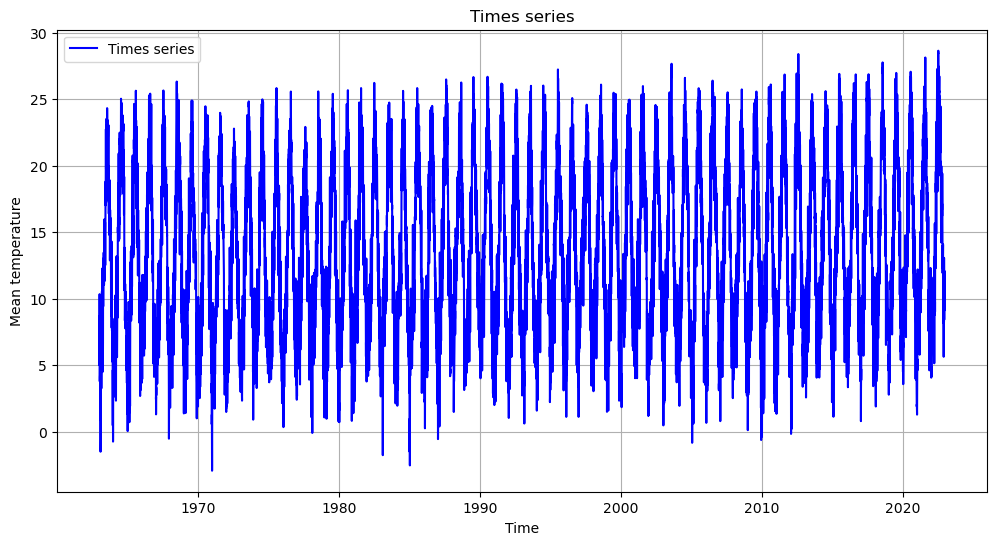

In [35]:
fig = Graphic_Serie(data_spain['Mean Temperature'])
plt.show()

It may be required to limit the time period for studying stationary.

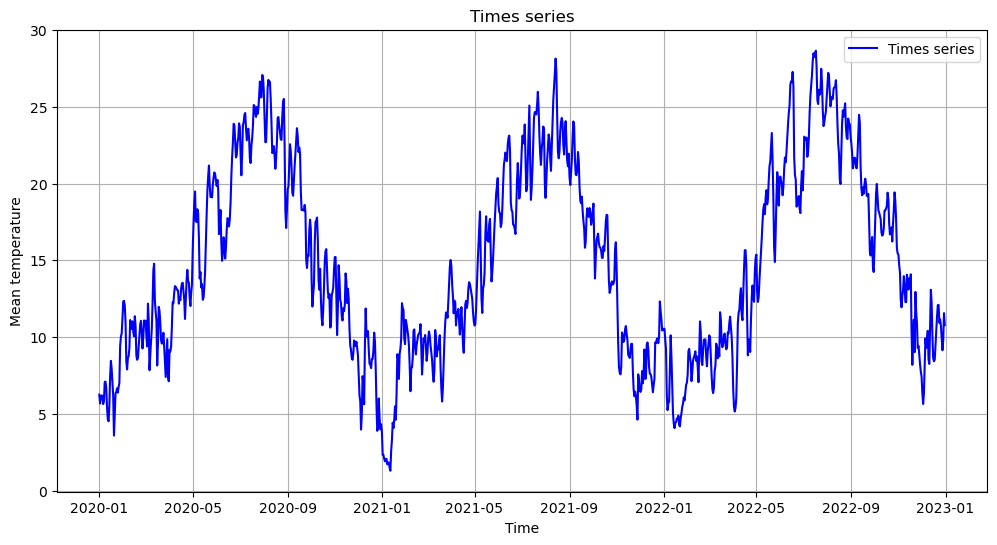

In [36]:
fig = Graphic_Serie(data_spain[data_spain.index.year.isin([2020, 2021, 2022])]['Mean Temperature'])
plt.show()

---------
### Partial conclusion

- By reducing the time interval of the time series, it is possible to observe that the series is non-stationary.

- The data graph illustrates a pattern where the temperature rises during summer and falls in the following months, repeating annually.

---------


<a name="item2.4.4"></a>
#### 2.4.4. Time series decomposition

In [33]:
def descomposition_serie (df):
    
    import statsmodels.api as sm

    # Realiza la descomposición de la serie de tiempo
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')

    # Extrae los componentes
    Trend = decomposition.trend
    Seasonal = decomposition.seasonal
    Resid = decomposition.resid

    # Graficar los componentes
    fig = plt.figure(figsize=(12, 8))

    plt.subplot(311) # subplot(num filas, num columnas, posición del subgráfico en esa cuadrícula
    plt.plot(Trend, label='Trend')
    plt.title('Trend component')
    plt.legend()

    plt.subplot(312)
    plt.plot(Seasonal, label='Seasonal')
    plt.title('Seasonal component')
    plt.legend()

    plt.subplot(313)
    plt.plot(Resid, label='Resid')
    plt.title('Resid component')
    plt.legend()

    plt.tight_layout()

    return fig

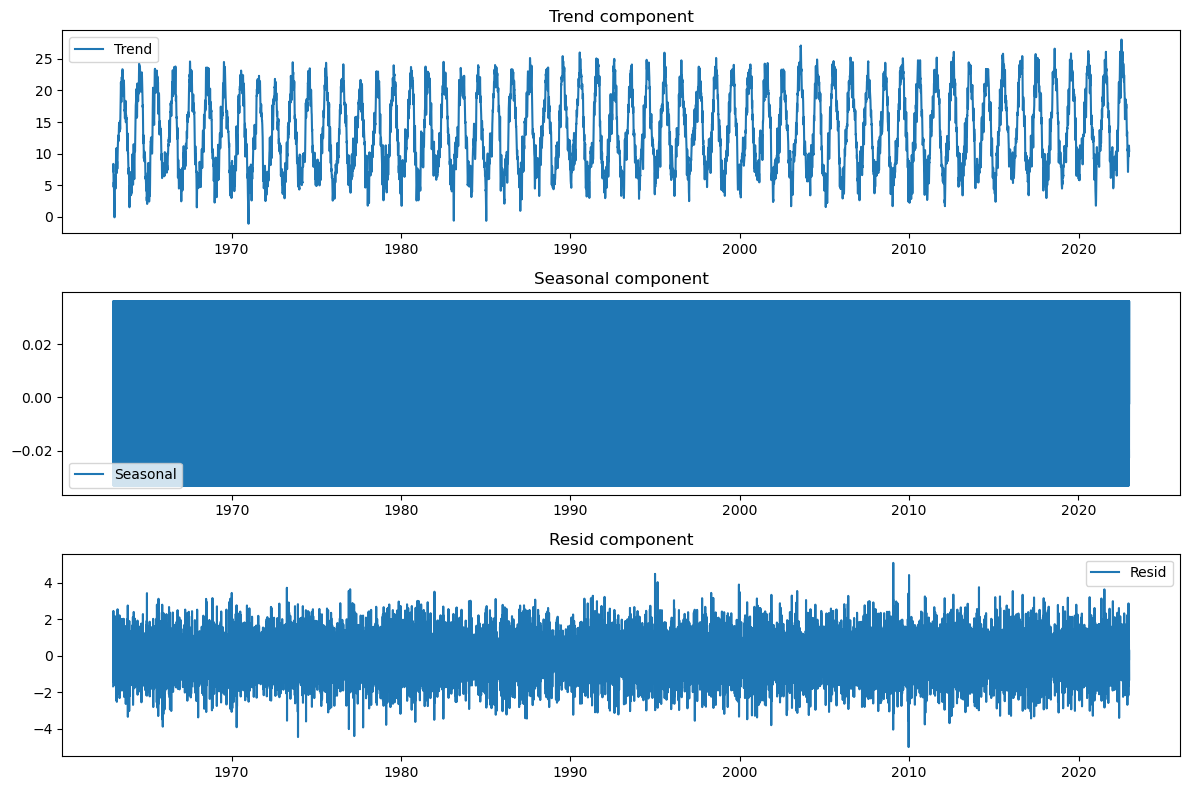

In [37]:
fig_desc = descomposition_serie(data_spain['Mean Temperature'])

plt.show()

The time range has been reduced in order to better observe the stationary behavior of the data.

The graph presented below illustrates the trend, seasonal, and residual components of data from the years 2020 to 2022.

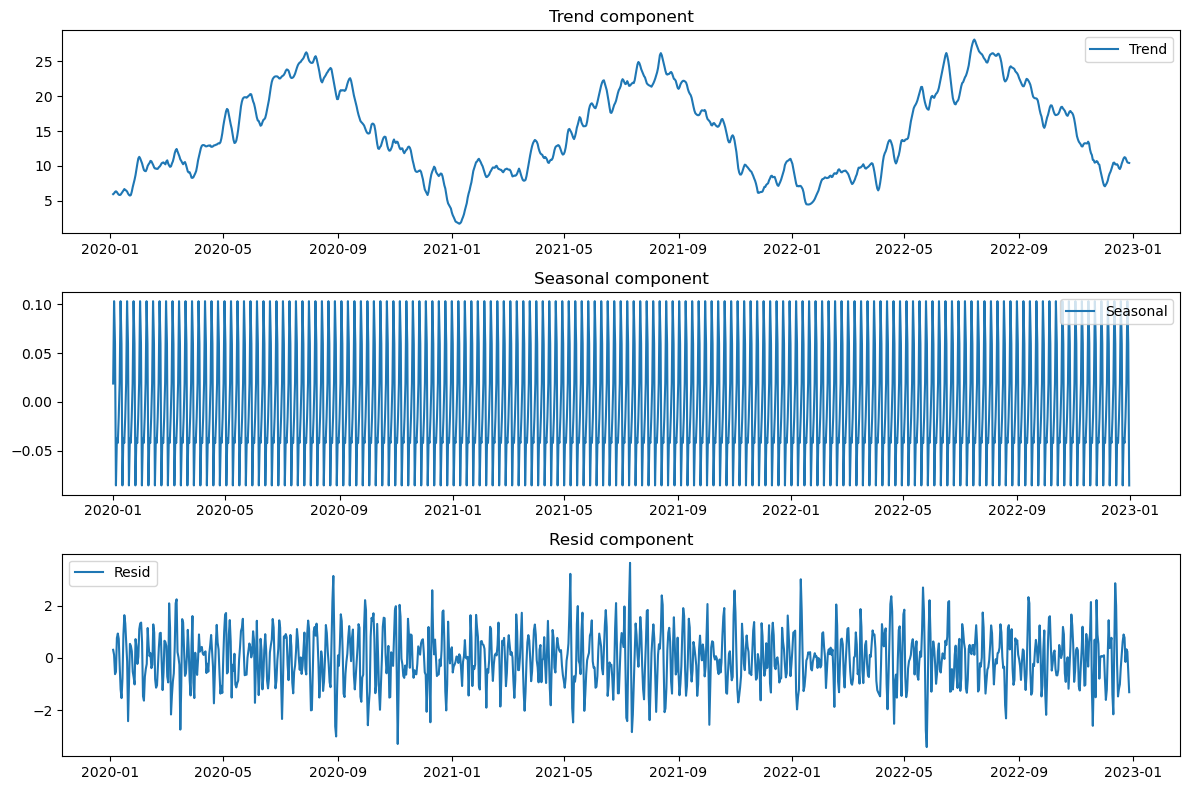

In [94]:
fig_desc = descomposition_serie(data_spain[data_spain.index.year.isin([2020, 2021, 2022])]['Mean Temperature'])
plt.show()

The below graphs only represent data for the year 2020.

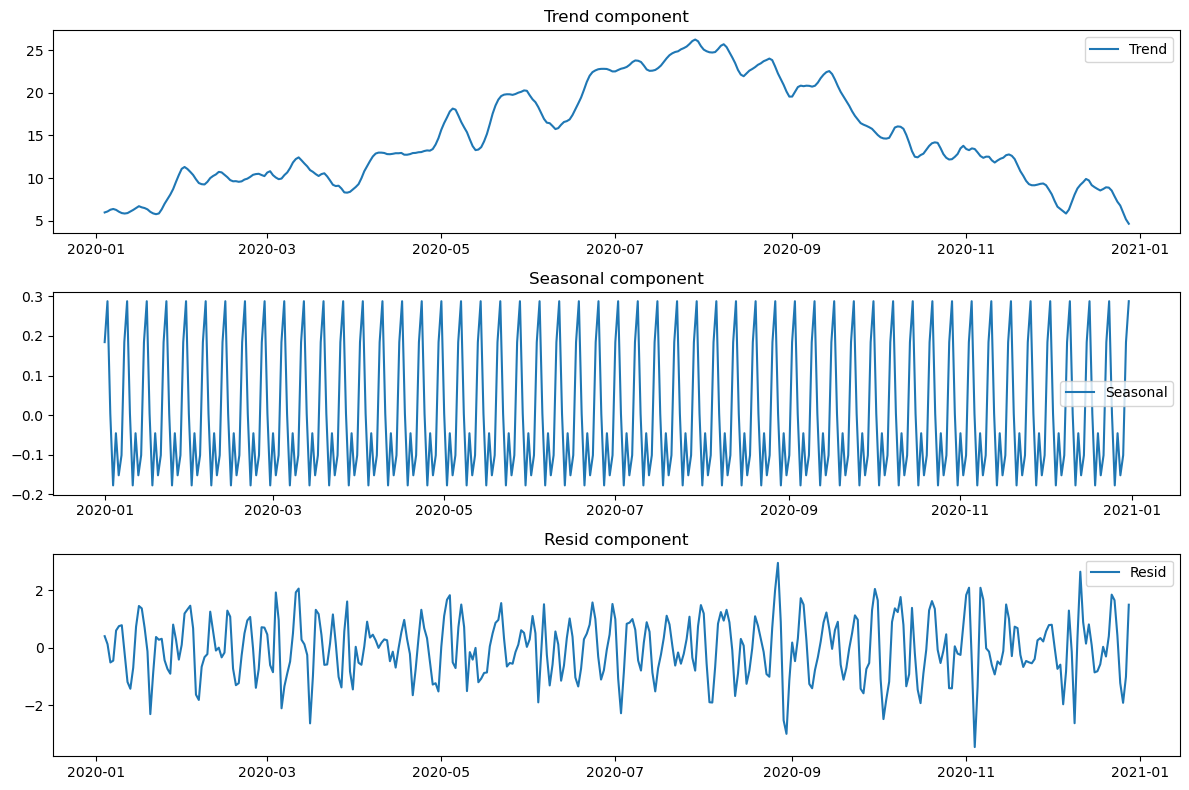

In [95]:
fig_desc = descomposition_serie(data_spain[data_spain.index.year.isin([2020])]['Mean Temperature'])
plt.show()

--------

### Partial conclusion
Upon examining the decomposition graphs, it becomes clear that:

- The trend component shows that the dataset has a temperature trend, with temperatures rising during the summer months and falling afterwards.
- The seasonal component displays repetitive patterns, indicating the presence of seasonality in the data. Without a seasonal component, the data would form a straight line with a value of zero or small variations around it.

The obtained results are consistent with the ones obtained through graphing the data series.

--------


<a name="item2.4.5"></a>
#### 2.4.5. Autocorrelation in Time Series Data

In [38]:
# Autocorrelation

def Autocorrelation (df):

    from statsmodels.graphics import tsaplots


    # Stands for Time Series Analysis Plots (TSA Plots)
    fig = plt.figure(figsize = (12,6))
    
    tsaplots.plot_acf(df, ax=fig.gca(), lags=60)

    plt.xlabel("Lag at k")
    plt.ylabel("Correlation coefficient")
    #plt.show()
    
    return fig

    #banda de confianza = zona celeste

    #El valor 0 siempre es 1 porque tiene una correlación perfecta con el paso de tiempo actual.

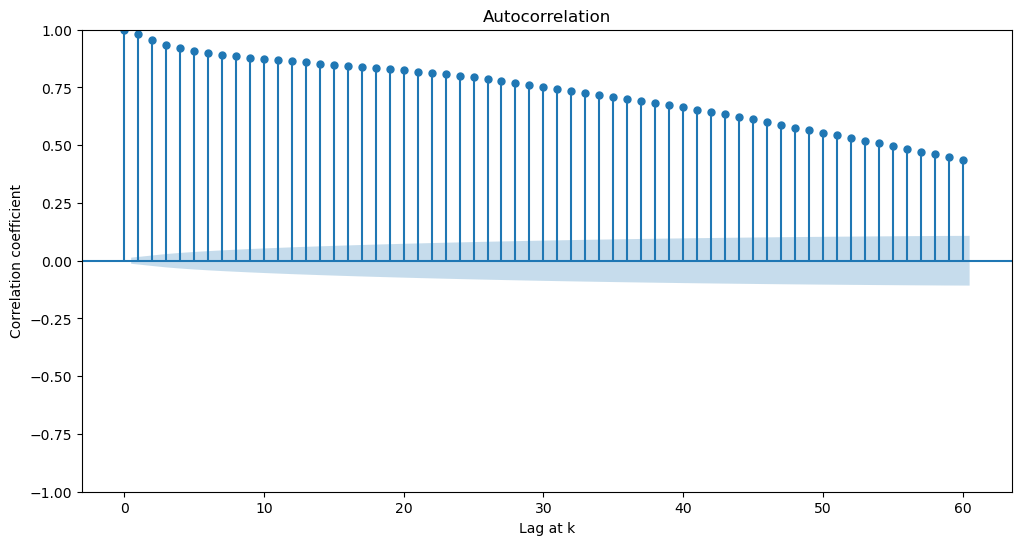

In [87]:
fig_ACF = Autocorrelation(data_spain['Mean Temperature'])
plt.show()

The blue shaded area on an autocorrelation plot typically represents confidence bounds, and values falling within this area are not considered statistically significant.


--------

### Partial conclusion

Significant values are observed (outside the blue area) that slowly decay. This demonstrates that time series is not stationarity because it has a trend.

On the other hand, if it decays rapidly to values close to zero, the time series would not have trend.

----

<a name="item2.4.6"></a>
#### 2.4.6. Partial Autocorrelation in Time Series Data

In [50]:
# partial autocorrelation

def Partial_Autocorrelation (df):

    from statsmodels.graphics import tsaplots

    fig = plt.figure(figsize = (12,6))
    
    tsaplots.plot_pacf(df, ax=fig.gca()) 

    plt.title("Partial Autocorrelation")
    plt.xlabel("Lag at k")
    plt.ylabel("Correlation Coefficient")
    #plt.show()
    
    return fig

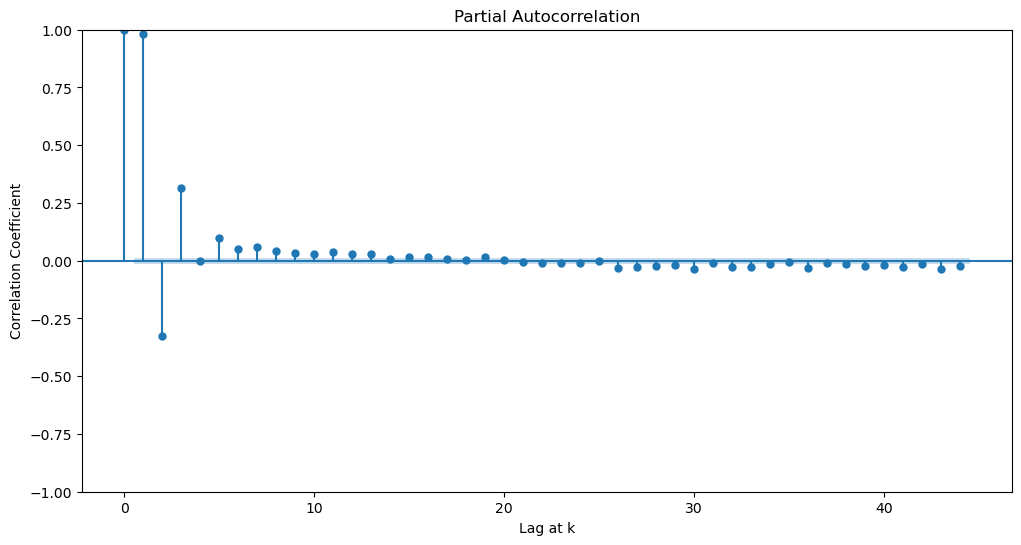

In [51]:
fig_PACF = Partial_Autocorrelation(data_spain['Mean Temperature'])

--------

### Partial conclusion
Most of the values are significant and outside the blue area, demonstrating a strong correlation between the data.

------

### Conclusion:

It is evident that the series has a trend and seasonality, indicating that it is not stationary. Therefore, the series must be differentiated to make it stationary.

-----

<a name="item3"></a>
## 3. Prediction models

<a name="item3.1"></a>
### 3.1. ARIMA

In [52]:
import pmdarima as pm
import statsmodels.api as sm

<a name="item3.1.1"></a>
#### 3.1.1. Train-Test Data Split

In [53]:
def Train_Test_data (df):
    
    # Calcula el número de datos que se utilizarán como entrenamiento (el 15%)
    test_percentage = 0.15
    num_test = int(len(df) * test_percentage)

    # Divide la serie de tiempo en datos de entrenamiento y datos de prueba
    X_train = df[:len(df)-num_test]
    X_test = df[len(df)-num_test:]
    
    print(f"Training data: {len(X_train)}")
    print(X_train.tail(5))
    print()
    print()
    print(f"Test data: {len(X_test)}")
    print(X_test.head(5))
    
    return X_train, X_test

In [54]:
X_train, X_test = Train_Test_data(data_spain['Mean Temperature'])

Training data: 18628
Time
2013-12-27    9.24
2013-12-28    7.93
2013-12-29    4.51
2013-12-30    4.27
2013-12-31    5.98
Freq: D, Name: Mean Temperature, dtype: float64


Test data: 3287
Time
2014-01-01     8.07
2014-01-02    10.08
2014-01-03    11.16
2014-01-04     8.68
2014-01-05     6.96
Freq: D, Name: Mean Temperature, dtype: float64


<a name="item3.1.2"></a>
#### 3.1.2. Auto ARIMA Model Selection Function

In [59]:
def S_ARIMA_options (X_train,d_values, D_values, startp, startq, maxp, maxq, startP, startQ, maxP, maxQ, m_value, seasonal_value, stationary_value):
   
    import warnings
    import pmdarima as pm

    # Suprimir todas las advertencias (warnings)
    warnings.filterwarnings("ignore")
        
    models = []
    
    if D_values == 0:
        
        for d_op in d_values:

                print(f" Alternative models with d: {d_op} and D: 0")
                print()

                model_arima = pm.auto_arima(
                            y                 = X_train,
                            d                 = d_op,
                            D                 = 0,
                            start_p           = startp,
                            start_q           = startq,
                            max_p             = maxp,
                            max_q             = maxq,
                            start_P           = startP,
                            start_Q           = startQ,
                            max_P             = maxP,
                            max_Q             = maxQ,
                            m                 = m_value,
                            #test              = 'kpss',
                            seasonal          = seasonal_value,
                            stationary       = stationary_value,
                            trace             = True, # habilitando la opción de seguimiento, se mostrara en pantalla los modelos evaluados
                            error_action      = 'ignore',
                            suppress_warnings = True,
                            stepwise          = True # la función realizará una búsqueda de paso hacia adelante para seleccionar los órdenes (p, d, q) del modelo ARIMA.
                        )

                dic = {"d"              : d_op,
                       "D"              : 0,
                       "Order"          : model_arima.get_params()['order'], 
                       "Seasonal order" : model_arima.get_params()['seasonal_order'],
                       "AIC"            : model_arima.aic()}

                #Se agrega la mejor alternativa
                models.append(dic) 
                print()
                print("***************************")
                print()
    else:
        for d_op in d_values:
            for D_op in D_values:

                print(f" Alternative models with d: {d_op} and D: {D_op}")
                print()

                model_arima = pm.auto_arima(
                            y                 = X_train,
                            d                 = d_op,
                            D                 = D_op,
                            start_p           = startp,
                            start_q           = startq,
                            max_p             = maxp,
                            max_q             = maxq,
                            start_P           = startP,
                            start_Q           = startQ,
                            max_P             = maxP,
                            max_Q             = maxQ,
                            m                 = m_value,
                            test              = 'kpss',
                            seasonal          = seasonal_value,
                            stationary       = stationary_value,
                            trace             = True, # habilitando la opción de seguimiento, se mostrara en pantalla los modelos evaluados
                            error_action      = 'ignore',
                            suppress_warnings = True,
                            stepwise          = True # la función realizará una búsqueda de paso hacia adelante para seleccionar los órdenes (p, d, q) del modelo ARIMA.
                        )

                dic = {"d"              : d_op,
                       "D"              : D_op,
                       "Order"          : model_arima.get_params()['order'], 
                       "Seasonal order" : model_arima.get_params()['seasonal_order'],
                       "AIC"            : model_arima.aic()}

                #Se agrega la mejor alternativa
                models.append(dic) 
                print()
                print("***************************")
                print()

    S_ARIMA_op = pd.DataFrame(models)
    
    return S_ARIMA_op

In [61]:
d_values = [0,1,2]
D_values = 0
startp= 0 
startq= 0 
maxp= 3 
maxq= 3 
startP= 0
startQ= 0
maxP= 0 
maxQ= 0 
m_value= 0 
seasonal_value= False #se deben ajustar componentes estacionales o no
stationary_value= False

# En el dataframe se guardan los mejores modelos con las combinaciones d y D
ARIMA_op = S_ARIMA_options (X_train, d_values, D_values, startp, startq, maxp, maxq, startP, startQ, maxP, maxQ, m_value, seasonal_value, stationary_value)

print(ARIMA_op)
print()
print("The best model is:")
print()
print(ARIMA_op.sort_values(by= 'AIC', ascending=True).head(1))

 Alternative models with d: 0 and D: 0

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=152825.168, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=127991.531, Time=0.97 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=54736.672, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=54667.006, Time=2.75 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=54112.507, Time=3.95 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=53636.297, Time=5.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=53745.047, Time=1.74 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=53630.925, Time=3.78 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=53628.677, Time=2.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=54013.270, Time=1.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=54603.114, Time=2.27

Se puede observar que hay alternativas que tiene intercept. Esto quiere decir con intercepción, es decir que se agrega unan constante al modelo. En esta configuración, el modelo ARIMA se ajusta con un término de intercepción. Esto significa que la serie de tiempo se modela con una componente de media constante. La elección entre un modelo con o sin intercepción depende de la estructura de tus datos y de cuál se ajusta mejor a ellos. Esto es útil cuando los datos tienen una tendencia o un nivel medio que se mantiene constante a lo largo del tiempo y que no puede explicarse mediante la estructura autoregresiva o de media móvil del modelo ARIMA.

<a name="item3.1.3"></a>
#### 3.1.3. ARIMA Model Creation

In [62]:
# Crear ARIMA Model 
model_arima = sm.tsa.ARIMA(X_train, order=(2, 0, 3))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Mean Temperature   No. Observations:                18628
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -26782.906
Date:                Thu, 11 Jan 2024   AIC                          53579.812
Time:                        19:43:10   BIC                          53634.639
Sample:                    01-01-1963   HQIC                         53597.812
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2492      0.779     17.000      0.000      11.722      14.777
ar.L1          1.5520      0.020     76.744      0.000       1.512       1.592
ar.L2         -0.5549      0.020    -27.792      0.0

<a name="item3.1.4"></a>
#### 3.1.4. Analysis of the prediction residual

The “residuals” in a time series model are what is left over after fitting a model. That is, the residual component represents the unexplained part of the time series that the model couldn't capture.

In [64]:
#resid es un atributo que contiene los residuos del modelo ARIMA
residuals = model_arima_fit.resid 
residuals.head(5)

Time
1963-01-01   -6.679202
1963-01-02    1.345001
1963-01-03   -3.617013
1963-01-04    2.170766
1963-01-05    1.815660
Freq: D, dtype: float64

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

**1. Normal Gaussian Pattern in Histogram:**

The histogram of residuals should show a normal Gaussian pattern with a centered peak. The width of the histogram provides insights into the dispersion of residual values. It illustrates the frequency of various residual values in the data series.

**2. Normal Gaussian Density:**

The density of residuals should follow a normal Gaussian distribution. Density represents the probability distribution of continuous variable values. The mode, where the curve reaches its maximum value, aligns with the mean and median in a normal distribution.

**3. Residuals Similar to White Noise:**

The graph of residuals should resemble white noise, which is a random signal with constant intensity across all frequencies. Residuals behaving like white noise indicate randomness and a lack of systematic patterns.

**4. Uncorrelated Residuals:**

Residuals should exhibit no correlations with each other. Autocorrelation Function (ACF) values for residuals should be low. Low ACF values imply that residuals lack predictive nature and are independent over time.

**5. Zero Mean of Residuals:**

Residuals should have a mean close to zero. A non-zero mean in residuals suggests bias in the forecasting process.

**6. Analyzing the decomposition of residuals:**

Decomposition allows you to identify any remaining patterns or structures in the residuals. A good forecasting model should leave residuals that are uncorrelated, have constant variance, and follow a normal distribution. Analyzing the decomposition of residuals helps in assessing whether the model meets these assumptions.

Evaluating residuals against these criteria helps ensure the reliability and adequacy of a time series forecasting model.

<a name="item3.1.4.1"></a>
##### 3.1.4.1. Histogram and Density

In [63]:
def Hist_Dens_resid (residuals):
    import seaborn as sns

    sns.set_style("whitegrid")  # Estilo del gráfico

    fig = plt.figure(figsize=(8, 6))

    # Crear un gráfico combinado de histograma y densidad de residuos
    sns.histplot(residuals, kde=True, color="b")
    plt.title('Histogram and Density of resid')
    plt.xlabel('Resid')
    plt.ylabel('Frequency/Density')

    return fig

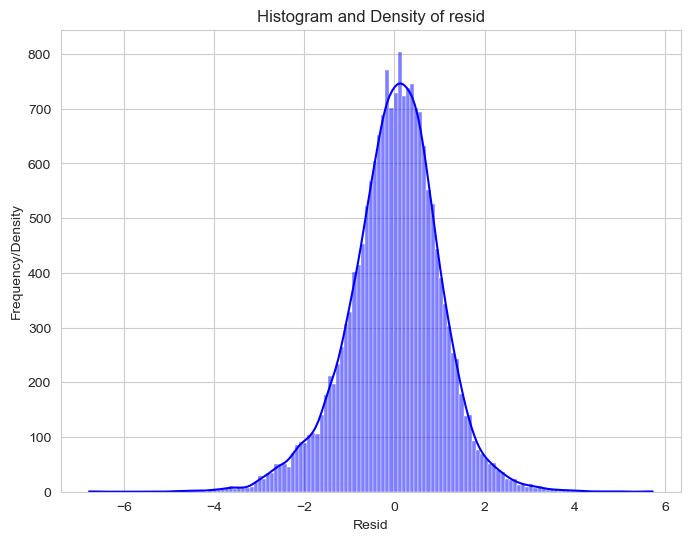

In [95]:
fig_hist_dens = Hist_Dens_resid(residuals)
plt.show()

----

### Parcial conclusion

In conclusion, the characteristics observed in the histogram of residuals, with a center around 0.3, a tail reaching 5.9, and another reaching 6.5, suggest that the model does not predict the data.

----

<a name="item3.1.4.2"></a>
##### 3.1.4.2. Residuals graph 

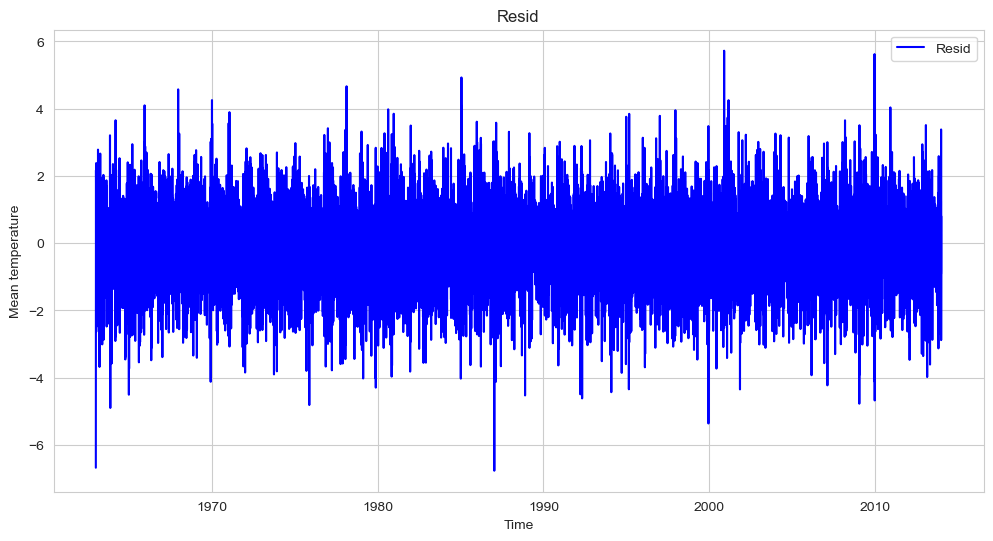

In [105]:
# Gráfico de línea de errores residuales

fig = Graphic_Serie(residuals, "Resid")


---
### Parcial conclusion

The residuals graph looks like white noise.

-----

<a name="item3.1.4.3"></a>
##### 3.1.4.3. Autocorrelation Function 

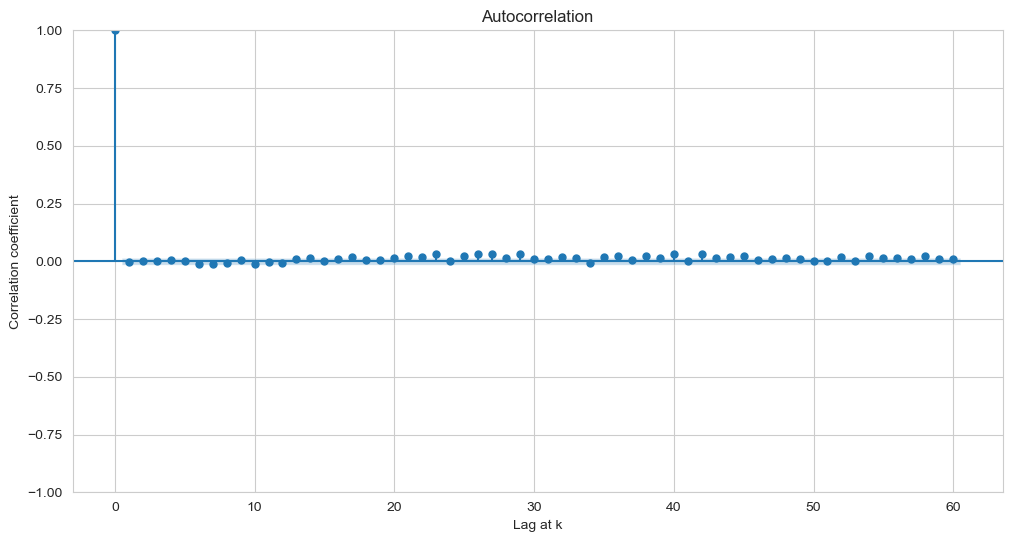

In [97]:
fig_ACF = Autocorrelation(residuals)


----
### Partial conclusion

When observing values slightly above the shaded area in the ACF of residuals, there might be patterns or structures in the residuals that haven't been fully captured by the model. 

----

<a name="item3.1.4.4"></a>
##### 3.1.4.4. Analyzing the decomposition of residuals

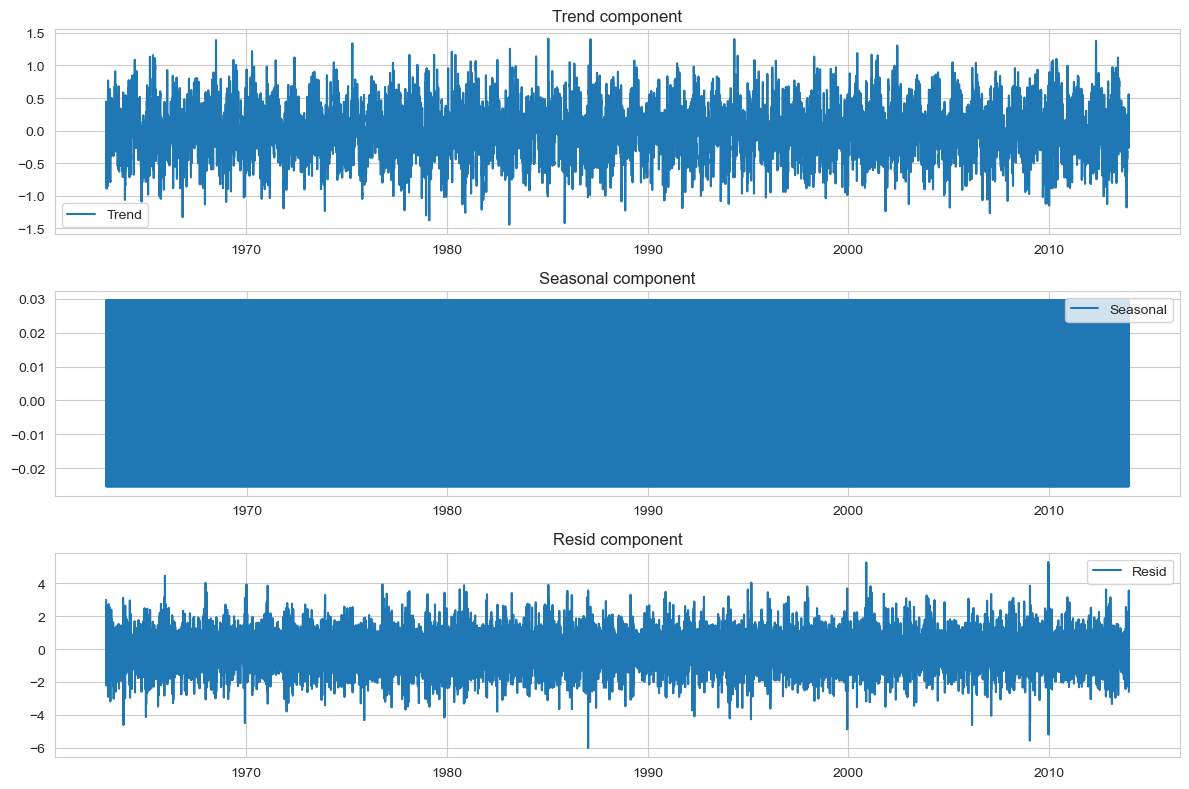

In [106]:
fig_desc = descomposition_serie(residuals)

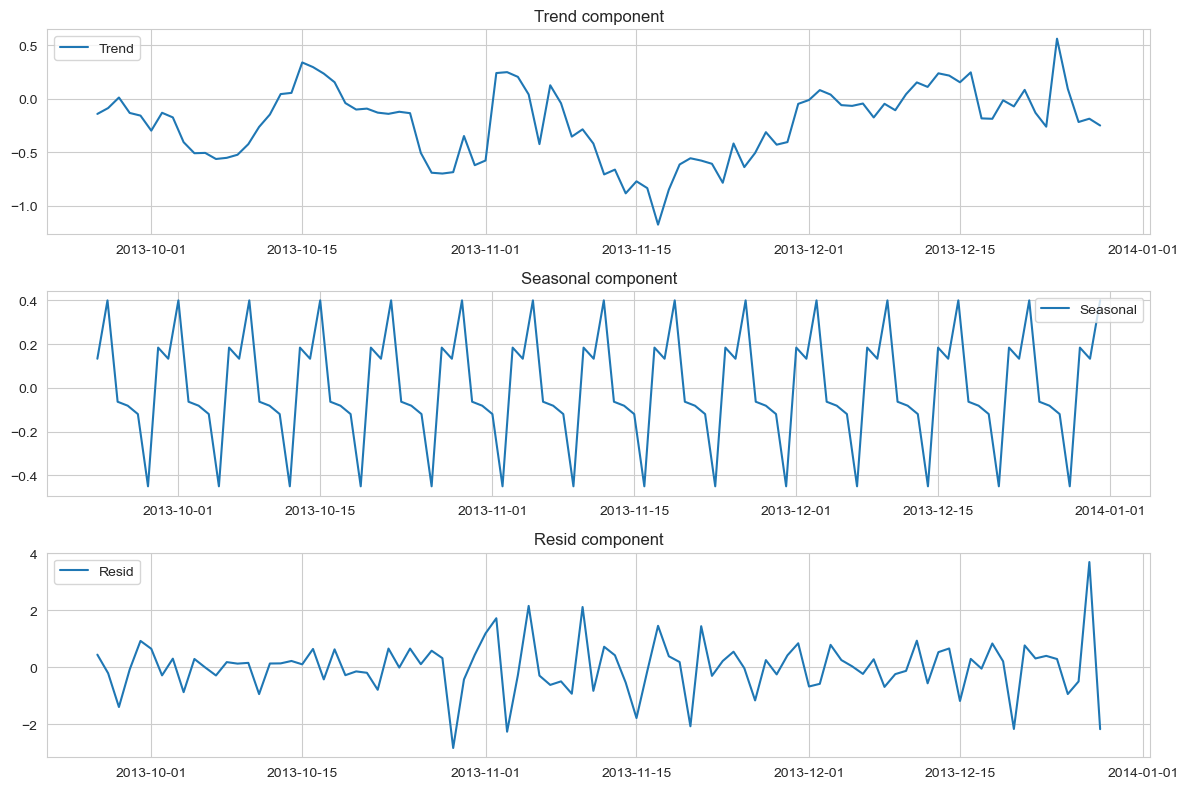

In [107]:
fig_desc = descomposition_serie(residuals[-100:])

----

### Parcial conclusion

When examining the decomposition of the residuals, patterns are observed in the series. This patterns indicate that the model did not succeed in making precise predictions.

----

<a name="item3.1.5"></a>
#### 3.1.5. Prediction

In [91]:
ARIMA_pred= model_arima_fit.get_prediction(start= len(X_train), end= len(X_train)+ len(X_test)-1)

In [92]:
print(ARIMA_pred)

In [93]:
import matplotlib.pyplot as plt

def Graphic_predict(X_train, X_test, model_predict):
    """
    Visualize predictions made by a time series model.

    Parameters:
    - X_train: DataFrame, training data with time series information.
    - X_test: DataFrame, testing data with time series information.
    - model_predict: Model prediction result object.

    Returns:
    - fig: Matplotlib Figure object.
    """
    try:
        # Get the predicted mean values
        predicted_mean = model_predict.predicted_mean

        # Get the confidence intervals (e.g., at 95%)
        confidence_interval = model_predict.conf_int(alpha=0.05)

        # Lower bound of the confidence interval
        lower_bound = confidence_interval.loc[:, 'lower Mean Temperature']

        # Upper bound of the confidence interval
        upper_bound = confidence_interval.loc[:, 'upper Mean Temperature']

    except:  # For Prophet model
        X_train = X_train.set_index('ds')
        X_test = X_test.set_index('ds')
        model_predict = model_predict.set_index('ds')

        # Get the predicted mean values
        predicted_mean = model_predict['yhat']

        # Lower bound of the confidence interval
        lower_bound = model_predict['yhat_lower']

        # Upper bound of the confidence interval
        upper_bound = model_predict['yhat_upper']

    # Create a figure with two subplots in one row and two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting training, testing, and prediction data on the first subplot
    ax1.plot(X_train, color="black", linestyle='-', label='Training Data')
    ax1.plot(X_test, color="blue", linestyle='-', label='Testing Data')
    ax1.fill_between(X_test.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval')
    ax1.plot(predicted_mean, color="red", linestyle='-', label='Model Predictions')
    ax1.set_title('Training, Testing, and Prediction Data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature Mean')
    ax1.legend()

    # Plotting testing and prediction data on the second subplot
    ax2.plot(X_test, color="blue", linestyle='-', label='Testing Data')
    ax2.fill_between(X_test.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval')
    ax2.plot(predicted_mean, color="red", linestyle='-', label='Model Predictions')
    ax2.set_title('Testing and Prediction Data')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature Mean')
    ax2.legend()

    return fig


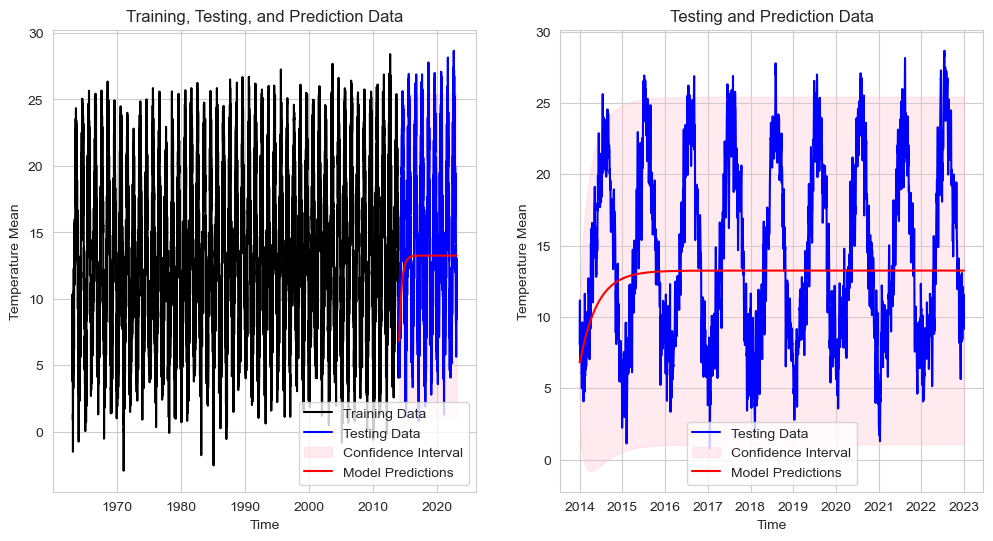

In [94]:
fig = Graphic_predict(X_train, X_test, ARIMA_pred)
plt.show()


----
### Partial conclusion

The results from the ARIMA model show a noticeable discrepancy from the actual data, indicating that the model's predictions do not align well with the real observations.

----

<a name="item3.1.6"></a>
#### 3.1.6. Model Metric

Although I already observe that the model doesn't align with the data, I will proceed to analyze the model metrics.

Model metrics help to evaluate the performance of a model and allows to qualitatively compare two models. 

The main metric that I am going to analyze is **coefficient of determination, or R-squared.**

R-squared, is a statistical measure that represents the proportion of the variance for a dependent variable that’s explained by an independent variable. That is, this is a measure that provides information about the goodness of fit of a model. It can range from 0 to 1.

In the context of a prediction model, "variance" generally refers to the variability or spread of values for a variable. Higher variance means that values are more spread out, while lower variance indicates that values tend to be closer to the mean.

- Dependent Variable (or Response): This is the variable you are trying to predict. In this case, it would be the future temperature.

- Independent Variable (or Predictor): This is the variable you are using to make the prediction. In this case, it is the past values of temperature that are used to predict the future temperature.

A perfect R-squared of 1.00 means that our predictor variables (in this case, it is Mean Temperature) explain 100% of the variance in the outcome we are trying to predict. In other words, an R-squared of 1.00 means that we can use the predictor variables to know precisely what the outcome’s value will be with no room for error. 

In [78]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

def Metrics (y_test,yhat):
    # Root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    # Relative Absolute Error
    RAE = np.sum(np.abs(np.subtract(y_test, yhat))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
    # Relative Square Error
    RSE = np.sum(np.square(np.subtract(y_test, yhat))) / np.sum(np.square(np.subtract(y_test, np.mean(y_test))))
    # R**2
    R2 = r2_score(y_test, yhat)

    print(f"MAE: {mean_absolute_error(y_test, yhat)}")
    print(f"MSE: {mean_squared_error(y_test, yhat)}")
    print('RMSE: %.3f' % rmse)
    print(f"R**2: {R2}")
    print(f"RAE: {RAE}")
    print(f"RSE: {RSE}")

In [88]:
Metrics(X_test.values,ARIMA_pred.predicted_mean.values)

MAE: 5.515610620857375
MSE: 42.22305464069846
RMSE: 6.498
R**2: -0.050742373895085846
RAE: 0.9992234375590094
RSE: 1.0507423738950858


----
### Partial conclusion
A negative R-squared can occur when the model performs worse than a simple model that predicts the mean of the dependent variable for all cases. In other words, the model isn't capturing any structure or pattern in the data and, instead, is making predictions that are worse than simply using the mean.

In this way, it confirmed that the model is not appropriate for this data.

----
